# **NL Classification from video games scripts dataset**

## **Import Necessary libraries**

In [1477]:
import matplotlib.pyplot as plt
import json # To open source files
import sys
from contextlib import redirect_stdout
import pandas as pd
import joblib # To save the trained models
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.model_selection import GridSearchCV




# import spacy #Unused
# import nltk #Unused
# from nltk.tokenize import word_tokenize #Unused
# from nltk.corpus import stopwords #Unused

## **Data Preparation**

### Load relevant games files :

In [1478]:
# Skyrim Data
skyrimPath = 'dataset/data/ElderScrolls/Skyrim'
# Final Fantasy XIII-2 Data
ffXIII_2Path = 'dataset/data/FinalFantasy/FFXIII-2'
# Horizon Zero Dawn Data (small dataset (~350 lines))
hZDPath = 'dataset/data/Horizon/HorizonZeroDawn'
#Hades dataset
hadesPath = 'dataset/data/Hades/Hades'
#DeathStranding dataset
DSPath = 'dataset/data/DeathStranding/DeathStranding'

def open_data_and_meta_files(paths):
    combinedData = []
    combinedMeta = []

    for path in paths :
        with open(path + '/data.json', 'r', encoding='utf-8') as file:
            data = json.load(file)
            combinedData.append(data)
        with open(path + '/meta.json', 'r', encoding='utf-8') as file:
            meta = json.load(file)
            combinedMeta.append(meta)
        
    return combinedData, combinedMeta

#Choose the dataset(s) to use
usedPaths = [hZDPath] #Paths to the datasets used
gameID = 'Horizon_Zero_Dawn' #To save trained models and other outputs with the game(s) name
wholeDataset = True #Whether to use the whole dataset or 20% of it to reduce computation time
 
if (wholeDataset) :
    wholeOrPart = "whole" #To create filenames
else :
    wholeOrPart = "part"

data, meta = open_data_and_meta_files(usedPaths)


### Define functions to process the opened files

In [1479]:
def extract_character_groups(meta):
    character_groups = meta["characterGroups"]
    character_to_group = {}
    for group, characters in character_groups.items():
        for character in characters:
            character_to_group[character] = group
    return character_to_group


# Recursive function to handle CHOICE entries
def process_entry(entryType, dialogue, dialogues, labels, character_names, character_groups_list, character_to_group):
    if entryType == "STATUS":
        return
    elif entryType == "_chunk":
        return
    elif entryType == "_TalkAgain":
        return
    elif entryType == "_INDENT":
        return
    elif entryType == "GOTO":
        return
    elif entryType == "LOCATION":
        return
    elif entryType == "ACTION" or entryType == "SYSTEM":
        if dialogue == "--" or dialogue == "---":
            return  # Skip empty ACTION or SYSTEM entries
        #Remove "[]" from the ACTION dialogue to avoid additional bias (useful for Skyrim dataset):
        dialogue = dialogue.replace("[", "").replace("]", "")
        labels.append("ACTION")
        dialogues.append(dialogue)
        character_names.append("ACTION")  #treat ACTION as CHARACTER for simplicity 
        character_groups_list.append("ACTION") 
    elif entryType == "CHOICE":
        # If it's a CHOICE, recursively process each option
        for choice in dialogue:  # Assuming dialogue is a list of choices
            if isinstance(choice, dict):  # Ensure choice is a dictionary
                for choiceType, choiceDialogue in choice.items():
                    process_entry(choiceType, choiceDialogue, dialogues, labels, character_names, character_groups_list, character_to_group)
            elif isinstance(choice, list):  # Handle nested lists (CHOICE inside CHOICE)
                for sub_choice in choice:
                    for sub_choiceType, sub_choiceDialogue in sub_choice.items():
                        process_entry(sub_choiceType, sub_choiceDialogue, dialogues, labels, character_names, character_groups_list, character_to_group)
            else:
                labels.append("CHARACTER")
                dialogues.append(dialogue)
                character_names.append(entryType)  # Add the character name
                character_groups_list.append(character_to_group.get(entryType, "unknown"))  # Map to group or "unknown"
    else :
        labels.append("CHARACTER")
        dialogues.append(dialogue)
        character_names.append(entryType)  # Add the character name
        character_groups_list.append(character_to_group.get(entryType, "unknown"))  # Map to group or "unknown"


def process_dataset(dataList, metaList) :
    dialogues = []
    labels = []
    character_names = []
    character_groups_list = []

    for data in dataList :
        #get data index in dataList
        dataIndex = dataList.index(data)
        character_to_group = extract_character_groups(metaList[dataIndex])
        for entry in data['text']:
            for entryType, dialogue in entry.items():
                process_entry(entryType, dialogue, dialogues, labels, character_names, character_groups_list, character_to_group)
        
    return dialogues, labels, character_names, character_groups_list

### Gather the data in a pandas DataFrame and print for verifications :

In [1480]:

def getDataFrame(data, meta, testGameID):
    dialogues, labels, character_names, character_groups_list = process_dataset(data, meta)
    df = pd.DataFrame({
        'dialogue': dialogues,
        'label': labels,
        'character_name': character_names,
        'character_group': character_groups_list
    })

    #save dataFrame to file
    df.to_csv(f"output/dataframe/" + testGameID + "_dataFrame.csv", index=False, encoding='utf-8')
    return df

df = getDataFrame(data, meta, gameID)

print(df)

                                              dialogue      label  \
0                   DATAPOINT: Log: Connor Chasson (1)     ACTION   
1    ... I mean, seriously, "Record our thoughts fo...  CHARACTER   
2                        DATAPOINT: Log: Skylar Rivera     ACTION   
3    And Machu Picchu. Always wanted to see that. N...  CHARACTER   
4                          DATAPOINT: Log: Ella Pontes     ACTION   
..                                                 ...        ...   
324    I'm okay with this. I want to go home. Goodbye.  CHARACTER   
325  That was the last transmission of Elisabet Sob...  CHARACTER   
326  This datapoint is obtained automatically durin...  CHARACTER   
327                     DATAPOINT: Emergency Recording     ACTION   
328  This datapoint is obtained and viewed automati...     ACTION   

      character_name character_group  
0             ACTION          ACTION  
1     Connor Chasson            male  
2             ACTION          ACTION  
3      Skylar R

### Preprocessing text (Not used, done by CountVectorizer)

In [1481]:
# # Download necessary NLTK data
# nltk.download('punkt')
# nltk.download('stopwords')

# # Load SpaCy model
# nlp = spacy.load("en_core_web_sm")

# # Preprocessing function
# def preprocess_text(text, nlp_model):
#     # Check if the input is not a string
#     if not isinstance(text, str):
#         print(f"Non-string input detected: {text}")
#         # Optionally, handle the non-string input here (e.g., join if it's a list)
#         if isinstance(text, list):
#             text = " ".join(text)
#         else:
#             # If it's not a list, convert it to a string
#             text = str(text)
#     # Tokenization and lowercasing
#     tokens = word_tokenize(text.lower())
#     # Remove stopwords
#     stop_words = set(stopwords.words('english'))
#     tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
#     # Lemmatization using SpaCy
#     doc = nlp_model(" ".join(tokens))
#     lemmatized = [token.lemma_ for token in doc]
#     return " ".join(lemmatized)


# # Apply preprocessing
# df['dialogue'].apply(lambda x: preprocess_text(x, nlp))


## **Define gridSearch Pipeline for the two classification tasks + statistics function**

### Define pipeline

In [ ]:
#IF YOU CHANGE THE PIPELINE CLASSIFIER, CHANGE THIS ID
ClassifierID = 'MLPClassifier' #To save trained models with the classifier name

# Define the pipeline
pipeline = Pipeline([

    #try HashingVectorizer instead of CountVectorizer
    #TODO
    ('vect', CountVectorizer()),
    #('vect', HashingVectorizer()),
    ('tfidf', TfidfTransformer()),

    #MultiLayerPerceptron Classifier
    ('scaler', StandardScaler(with_mean=False)),  # Add scaling for MLP
    ('clf', MLPClassifier()),

    #Random Forest Classifier  
    #('clf', RandomForestClassifier()),

    #Naive Bayes Classifier
    #('clf', MultinomialNB()),

    #SGDClassifier
    #('clf', SGDClassifier()),

    #SVC
    # ('scaler', StandardScaler(with_mean=False)),  # Add scaling for SVM
    # ('clf', SVC())
])

# Define hyperparameters for GridSearch
parameters = {
    'vect__ngram_range': [(1, 2), (1, 3)],
    'vect__strip_accents': ['ascii'],
    'vect__stop_words': (None, 'english'),
    'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),

    #MLPClassifier parameters
    'clf__hidden_layer_sizes': [(100), (100, 100)],
    'clf__batch_size': [32, 'auto'],
    'clf__activation': ['relu'],
    'clf__solver': ['adam'],
    'clf__alpha': [0.0001, 0.00001],
    'clf__max_iter': [100],
    'clf__verbose' : [True],
    'clf__momentum' : [0.9, 0.8],
    'clf__early_stopping' : [True],

    #Random Forest parameters
    # 'clf__n_estimators': [100, 200],
    # 'clf__max_depth': [20],
    # 'clf__min_samples_split': [2, 5],
    # 'clf__min_samples_leaf': [1, 2],
    # 'clf__max_features': ['sqrt', 'log2'],
    # 'clf__class_weight': ['balanced'],
    # 'clf__criterion': ['gini', 'entropy', 'log_loss'],
    # 'clf__min_weight_fraction_leaf': [0.0, 0.1],


    #SVC parameters
    # 'clf__kernel': ['linear', 'rbf', 'poly'],
    # 'clf__gamma': ['scale', 'auto'],
    # 'clf__coef0': [0, 1],
    # 'clf__degree': [3, 4],
    # 'clf__probability': [False, True],
    # 'clf__class_weight': ['balanced', None],
    # 'clf__max_iter': [100],
    # 'clf__tol': [1e-2, 1e-3],
    # 'clf__verbose' : [True],
    
    #MultinomialNBClassifier parameters
    #  'clf__alpha': [1e-1, 1e-2, 1e-3],
    #  'clf__force_alpha': [True, False],
    #  'clf__fit_prior': [False],


    #SGDClassifier parameters
    # 'clf__alpha': [1e-3, 1e-4, 1e-5],
    # 'clf__loss': ['hinge', 'log_loss', 'squared_hinge'],
    # 'clf__penalty': ['l2', 'l1', 'elasticnet'],
    # 'clf__max_iter': [250],
    # 'clf__class_weight': ['balanced', None],
    # 'clf__tol': [None, 1e-2, 1e-3, 1e-5],
    # 'clf__verbose' : [True],
}


### Function to obtain statistics about the dataset

In [1483]:
#Get statistics about the dataset
def getStatisticsBinaryClassification(df, labelsLabel, label1, label2):
    # Count the number of dialogues
    num_entries = len(df)

    num_label1 = df[df[labelsLabel] == label1].count()['dialogue']
    num_label2 = df[df[labelsLabel] == label2].count()['dialogue']
    
    # Count the number of unique characters
    num_unique_characters = df['character_name'].nunique()
    
    # Count the number of unique groups
    num_unique_groups = df['character_group'].nunique()
    
    # Count the number of dialogues per character
    dialogues_per_character = df['character_name'].value_counts()
    
    # Count the number of dialogues per group
    dialogues_per_group = df['character_group'].value_counts()
    
    percentage_of_label1 = (num_label1 / num_entries) * 100
    percentage_of_label2 = (num_label2 / num_entries) * 100

    stats =" num_entries : " + str(num_entries)
    stats +="\n\n" + label1 + " : " + str(num_label1)
    stats +="\npercentage of " + label1 + " : " + str(percentage_of_label1) + "%"
    stats +="\n\n" + label2 + " : " + str(num_label2)
    stats +="\npercentage of " + label2 + " : " + str(percentage_of_label2) + "%"
    stats +="\n\nnum_unique_characters : " + str(num_unique_characters)
    stats +="\ncharacters with most dialogues : \n" + str(dialogues_per_character.head())
    stats +="\n\nnum_unique_groups : " + str(num_unique_groups)
    stats +="\ndialogues_per_group : \n" + str(dialogues_per_group)

    print(stats)

    #Save to file
    with open("output/stats/" + gameID + "_" + ClassifierID + "_" + label1 + "_" + label2 + '_stats.txt', 'w') as f:
        f.write(stats)

## **ACTION/CHARACTER Classification**

### Split the dataset

#### Check there is only Characters and Actions in the dataset :

In [1484]:
#Check we only have Characters and actions in the original dataset :
print(df[(df['label'] != 'CHARACTER') & (df['label'] != 'ACTION')])

Empty DataFrame
Columns: [dialogue, label, character_name, character_group]
Index: []


#### Check the dataset repartition prior to splitting : 

In [1485]:
getStatisticsBinaryClassification(df, 'label', 'CHARACTER', 'ACTION')

 num_entries : 329

CHARACTER : 213
percentage of CHARACTER : 64.74164133738601%

ACTION : 116
percentage of ACTION : 35.25835866261398%

num_unique_characters : 36
characters with most dialogues : 
character_name
ACTION              116
Elisabet Sobeck      29
Ted Faro             26
Female Counselor     23
GAIA                 17
Name: count, dtype: int64

num_unique_groups : 4
dialogues_per_group : 
character_group
ACTION     116
female     113
male        96
unknown      4
Name: count, dtype: int64


#### Split dataset for training and testing

In [1486]:

if(wholeDataset) :
    X_train, X_test, y_train, y_test = train_test_split(df['dialogue'], df['label'], test_size=0.2, shuffle=True, random_state=42)

else :
    #Split the dataset a first time to keep 20% of it
    X_temp, X_dump, y_temp, y_dump = train_test_split(df['dialogue'], df['label'], test_size=0.8, shuffle=True, random_state=42)

    #Split for training and testing (20% for testing)
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.2, shuffle=True, random_state=42)


#### Check repartition of labels in the obtained sets

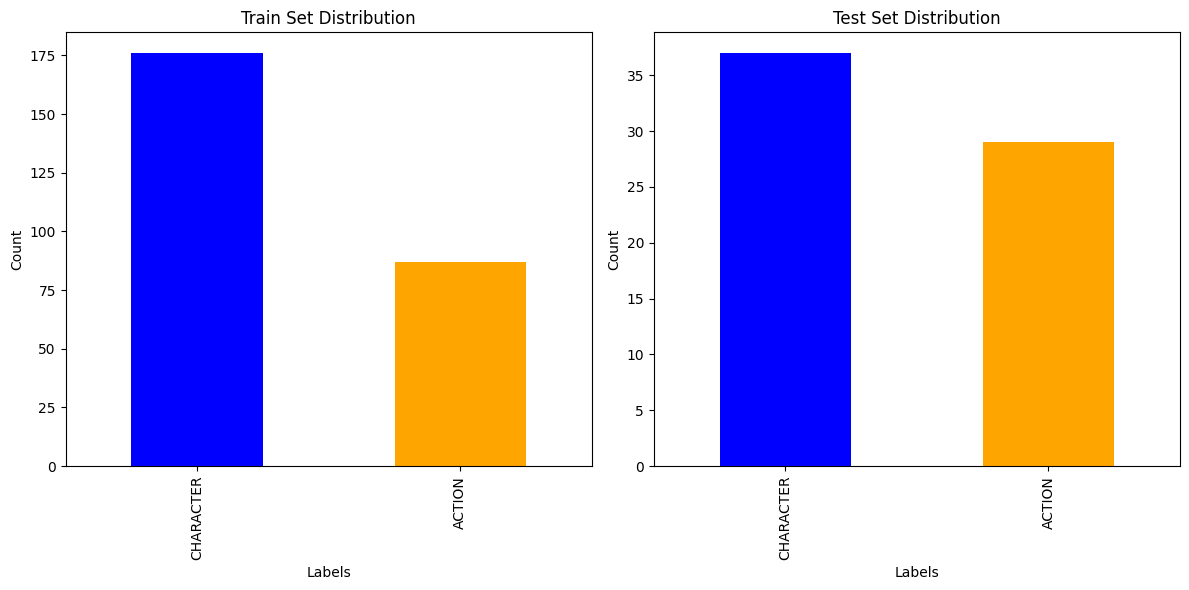

Train set distribution:
label
CHARACTER    66.920152
ACTION       33.079848
Name: count, dtype: float64

Test set distribution:
label
CHARACTER    56.060606
ACTION       43.939394
Name: count, dtype: float64


In [1487]:
def checkRepartition(y_train, y_test, actionOrGender):
    # Count the number of entries for each label in the train set
    train_counts = y_train.value_counts()
    test_counts = y_test.value_counts()

    # Plotting the distribution
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Train set
    train_counts.plot(kind='bar', ax=ax[0], color=['blue', 'orange'])
    ax[0].set_title('Train Set Distribution')
    ax[0].set_xlabel('Labels')
    ax[0].set_ylabel('Count')

    # Test set
    test_counts.plot(kind='bar', ax=ax[1], color=['blue', 'orange'])
    ax[1].set_title('Test Set Distribution')
    ax[1].set_xlabel('Labels')
    ax[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

    percentage_train = (train_counts / len(y_train)) * 100
    percentage_test = (test_counts / len(y_test)) * 100
    print("Train set distribution:")
    print(str(percentage_train))
    print("\nTest set distribution:")
    print(str(percentage_test))

    #Save plots to file
    fig.savefig("output/repartition/" + gameID + "_" + ClassifierID + "_" + actionOrGender + "_" + wholeOrPart + "_train_test_distribution.png")
    #Save percentages to file



checkRepartition(y_train, y_test, actionOrGender='action')
    

### Train the Model

#### Perform grid search and print best parameters : 

In [1488]:
# Perform GridSearch
grid_search = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1, scoring='f1_macro', verbose=1)


lossFileName = "output/fitting_loss/" + gameID + "_" + ClassifierID + "_action_" + wholeOrPart + "_grid_search_output.txt"
with open(lossFileName, "w") as f:
    with redirect_stdout(f): #Redirect output to save loss evolution
        # Train the model with the best parameters
        grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

#save parameters to file
with open("output/parameters/" + gameID + "_" + ClassifierID + "_action" + "_" + wholeOrPart + "_best_parameters.txt", 'w') as f:
    f.write(str(grid_search.best_params_))

Best parameters: {'clf__alpha': 0.1, 'clf__fit_prior': False, 'clf__force_alpha': True, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__strip_accents': 'ascii'}


#### Check if a specific fold performs better to adjust the gridSearch parameters if needed

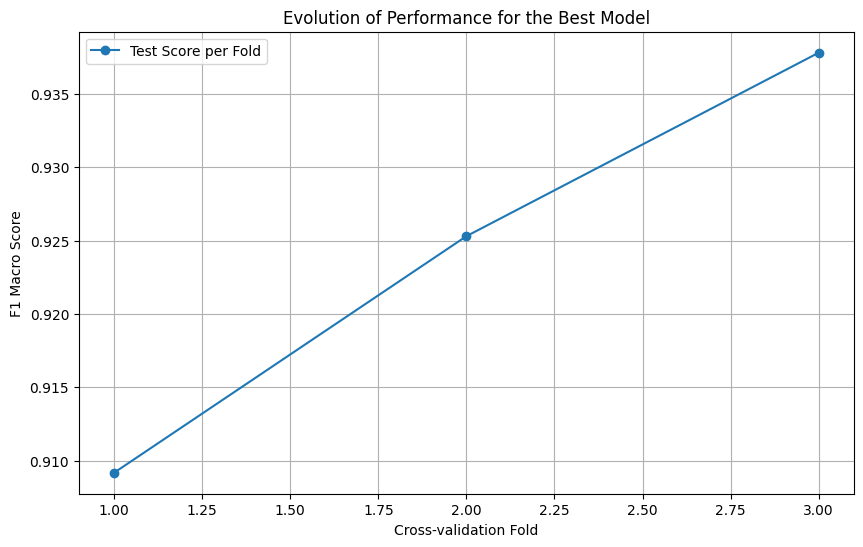

In [1489]:
def plot_cv_performance(grid_search, actionOrGender):
    # Extract the mean test scores and standard deviations for the best model
    best_index = grid_search.best_index_  # Index of the best model

    # Extract scores for each fold of the best model
    split_test_scores = [
        grid_search.cv_results_[f'split{i}_test_score'][best_index]
        for i in range(grid_search.cv)
    ]

    # Plot the evolution of performance for the best model
    plt.figure(figsize=(10, 6))
    plt.plot(
        range(1, grid_search.cv + 1),  # Cross-validation fold indices (1-based)
        split_test_scores,
        marker='o',
        label='Test Score per Fold'
    )
    plt.xlabel('Cross-validation Fold')
    plt.ylabel('F1 Macro Score')
    plt.title('Evolution of Performance for the Best Model')
    plt.legend()
    plt.grid()
    
    # Save the plot to a file
    plt.savefig("output/cv_performance/" + gameID + "_" + ClassifierID + "_" + actionOrGender + "_" + wholeOrPart + "_cv_performance.png")

    plt.show()

plot_cv_performance(grid_search, actionOrGender='action')

#### Plot loss curve for MLP Classifier to check for overfitting

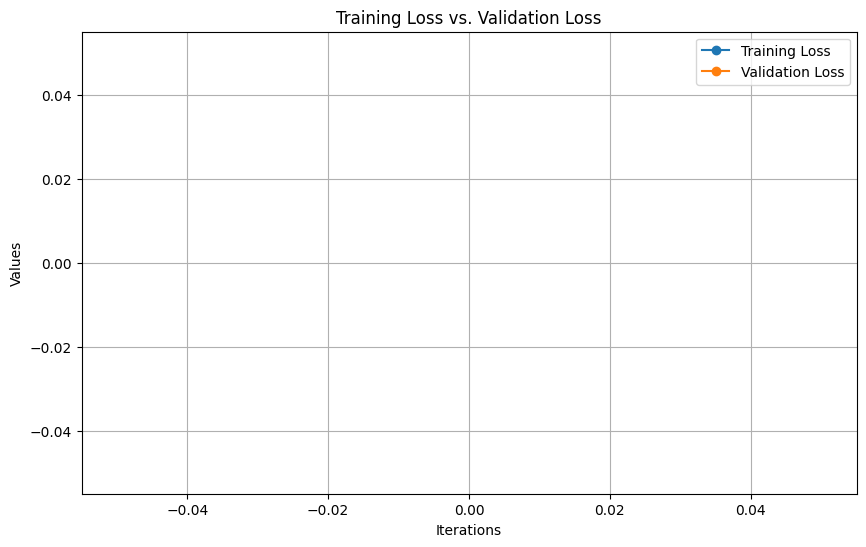

In [1490]:
import re
import matplotlib.pyplot as plt

def extract_loss_and_validation(file_path):
    """
    Extracts loss and validation scores from the output file.
    """
    train_loss = []
    val_scores = []

    # Regular expressions to match loss and validation score
    loss_pattern = re.compile(r"loss = ([0-9]*\.[0-9]+)")  # Matches "loss = 0.55292625"
    val_score_pattern = re.compile(r"Validation score: ([0-9]*\.[0-9]+)")  # Matches "Validation score: 0.883929"

    with open(file_path, "r") as file:
        for line in file:
            # Match training loss
            loss_match = loss_pattern.search(line)
            if loss_match:
                train_loss.append(float(loss_match.group(1)))

            # Match validation score
            val_score_match = val_score_pattern.search(line)
            if val_score_match:
                val_scores.append(1 - float(val_score_match.group(1)))

    return train_loss, val_scores

def plot_loss_and_validation(train_loss, val_scores):
    
    """
    Plots the training loss and validation scores.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label="Training Loss", marker="o")
    plt.plot(val_scores, label="Validation Loss", marker="o")
    plt.title("Training Loss vs. Validation Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Values")
    plt.legend()
    plt.grid()
    plt.savefig("output/loss_vs_validation_score.png")  # Save the plot to a file
    
    # Corrected code
    plotFileName = lossFileName.replace(".txt", "_plot.png")

    #Save plot to file
    plt.savefig(plotFileName)
    plt.show()

# Extract loss and validation scores
train_loss, val_scores = extract_loss_and_validation(lossFileName)

# Plot the loss and validation scores
plot_loss_and_validation(train_loss, val_scores)

#### Save the model if needed later

In [1491]:
filename = "output/trained_models/" +gameID + "_action_character_model_"+ ClassifierID + "_" + wholeOrPart + ".pkl"
# Save the Action/Character model
joblib.dump(grid_search, filename)
print("Action/Character model saved as " + filename)

Action/Character model saved as output/trained_models/Horizon_Zero_Dawn_action_character_model_MultinomialNB_whole.pkl


### Evaluate the model :

#### Predict on the test set and print classification report

In [1492]:
y_pred = best_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Save the classification report to a file
with open("output/classification_report/" + gameID + "_" + ClassifierID + "_action_character_" + wholeOrPart + "classification_report.txt", 'w') as f:
    f.write(classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

      ACTION       0.91      1.00      0.95        29
   CHARACTER       1.00      0.92      0.96        37

    accuracy                           0.95        66
   macro avg       0.95      0.96      0.95        66
weighted avg       0.96      0.95      0.95        66



#### Plot Confusion Matrix :

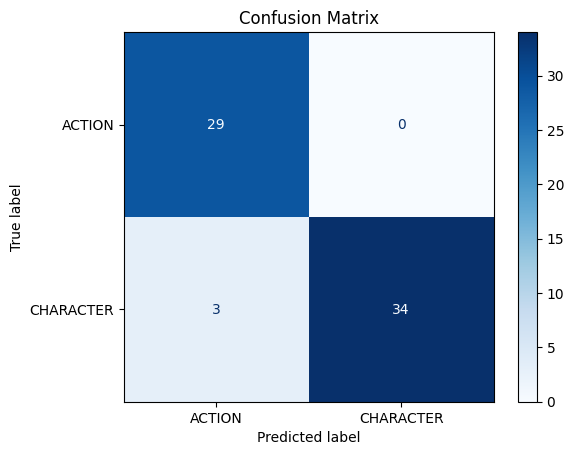

In [1493]:
def plot_confusion_matrix(y_true, y_pred, classes, actionOrGender):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    
    # Save the confusion matrix to a file
    plt.savefig("output/confusion_matrix/" + gameID + "_" + ClassifierID + "_" + actionOrGender + "_" + wholeOrPart + "_confusion_matrix.png")

    plt.show()

    
# Plotting the confusion matrix
plot_confusion_matrix(y_test, y_pred, best_model.classes_, actionOrGender='action')


#### Print Wrong Cases to get an overview

In [1494]:
#plot metrics on predicted data :

def print_wrong_cases(y_pred, y_test, X_test, actionOrGender):
    # Print the cases where the model was wrong
    print("Cases where the model was wrong:")

    # Save the wrong cases to a file
    with open("output/wrong_cases/" + gameID + "_" + ClassifierID + "_" + actionOrGender + "_" + wholeOrPart + "_wrong_cases.txt", 'w') as f:
        for i in range(len(y_pred)):
            if y_pred[i] != y_test.iloc[i]:
                f.write(f"Predicted: {y_pred[i]}, Actual: {y_test.iloc[i]}, Dialogue: {X_test.iloc[i]}\n")
                print(f"Predicted: {y_pred[i]}, Actual: {y_test.iloc[i]}, Dialogue: {X_test.iloc[i]}")

print_wrong_cases(y_pred, y_test, X_test, actionOrGender='action')

Cases where the model was wrong:
Predicted: ACTION, Actual: CHARACTER, Dialogue: (garbled) with Susanne Alpert, environmental scientist. Doctor?
Predicted: ACTION, Actual: CHARACTER, Dialogue: This datapoint is obtained automatically during the main quest The Mountain that Fell. It cannot be missed.
Predicted: ACTION, Actual: CHARACTER, Dialogue: This datapoint is obtained automatically during the main quest The Heart of the Nora while exploring ELEUTHIA-9. It cannot be missed.


## **MALE/FEMALE dialogue origin Classification**

### Adjust and split the dataset

#### Remove Actions and ungendered characters (and print for verification): 

In [1495]:
def process_dataset_for_gender_classification(df): 

    #Splice the dataFrame and remove non-CHARACTER labels as well as non-gendered characters
    df_character = df[df['label'] == 'CHARACTER']

    df_gender = df_character[(df_character['character_group'] == 'male') | (df_character['character_group'] == 'female')]

    #print the difference
    print("Original DataFrame size:", df.shape)
    print("Character filtered DataFrame size:", df_character.shape)
    print("Gender filtered DataFrame size : ", df_gender.shape) 
    print("\nNon-gendered lines filtering removed :")
    print(df_character[(df_character['character_group'] != 'male') & (df_character['character_group'] != 'female')])
    df_gender = df_gender.drop(columns=['label'])

    return df_gender

df_gender = process_dataset_for_gender_classification(df)

Original DataFrame size: (329, 4)
Character filtered DataFrame size: (213, 4)
Gender filtered DataFrame size :  (209, 4)

Non-gendered lines filtering removed :
                                              dialogue      label  \
109  Captain Okilo. Are you trying to thank me for ...  CHARACTER   
111  When it came to my country's lithium, it was a...  CHARACTER   
113  Yes, and I've got the prosthetic limbs to show...  CHARACTER   
115  As your General Herres said. So then. You did ...  CHARACTER   

    character_name character_group  
109  Captain Okilo         unknown  
111  Captain Okilo         unknown  
113  Captain Okilo         unknown  
115  Captain Okilo         unknown  


#### Check the dataset repartition prior to splitting

In [1496]:
getStatisticsBinaryClassification(df_gender, 'character_group', 'male', 'female')

 num_entries : 209

male : 96
percentage of male : 45.933014354066984%

female : 113
percentage of female : 54.066985645933016%

num_unique_characters : 34
characters with most dialogues : 
character_name
Elisabet Sobeck     29
Ted Faro            26
Female Counselor    23
GAIA                17
Charles Ronson       9
Name: count, dtype: int64

num_unique_groups : 2
dialogues_per_group : 
character_group
female    113
male       96
Name: count, dtype: int64


#### Split the dataset

In [1497]:
if(wholeDataset) :
    X_train, X_test, y_train, y_test = train_test_split(df_gender['dialogue'], df_gender['character_group'], test_size=0.2, shuffle=True, random_state=42)

else:

    #Split the dataset a first time to keep 20% of it
    X_temp, X_dump, y_temp, y_dump = train_test_split(df_gender['dialogue'], df_gender['character_group'], test_size=0.8, shuffle=True, random_state=42)

    #Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.2, shuffle=True, random_state=42)


#### Check repartition of labels in obtained sets

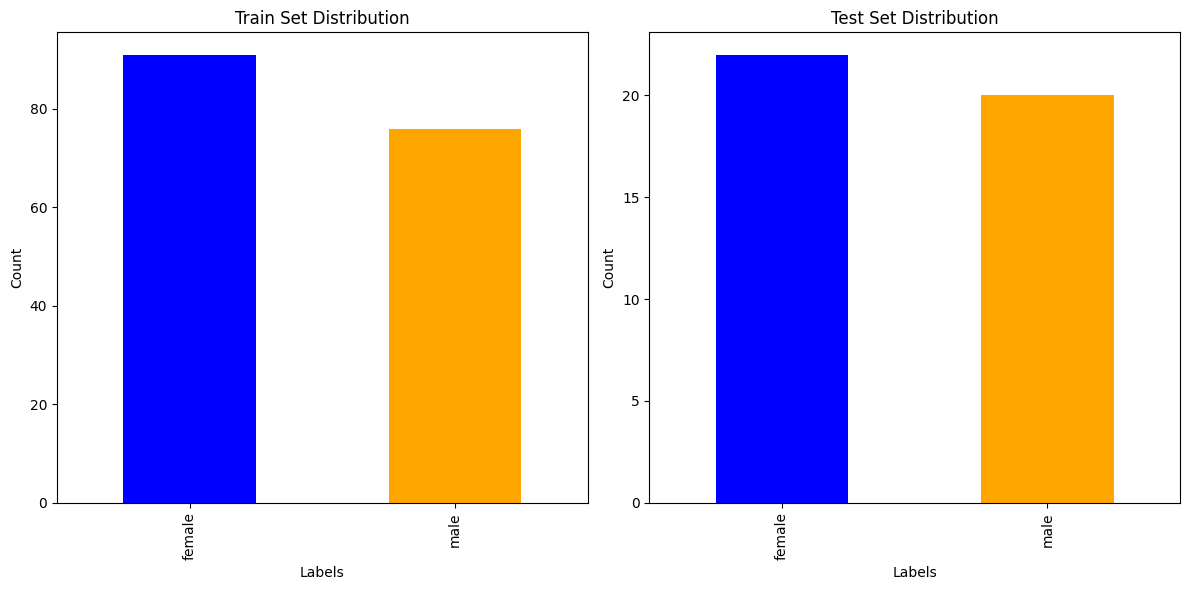

Train set distribution:
character_group
female    54.491018
male      45.508982
Name: count, dtype: float64

Test set distribution:
character_group
female    52.380952
male      47.619048
Name: count, dtype: float64


In [1498]:
checkRepartition(y_train, y_test, actionOrGender='gender')

### Train the model

#### Perform gridSearch and print best parameters

In [1499]:
#start grid_search again to check if our model would be the best one :
grid_search = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1, scoring='f1_macro', verbose=1)

lossFileName = "output/fitting_loss/" + gameID + "_" + ClassifierID + "_gender_" + wholeOrPart + "_grid_search_output.txt"
with open(lossFileName, "w") as f:
    with redirect_stdout(f): #Redirect output to save loss evolution
        # Train the model with the best parameters
        grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


#save parameters to file
with open("output/parameters/" + gameID + "_" + ClassifierID + "_gender_" + wholeOrPart + "_best_parameters.txt", 'w') as f:
    f.write(str(grid_search.best_params_))

Best parameters: {'clf__alpha': 0.1, 'clf__fit_prior': False, 'clf__force_alpha': True, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__strip_accents': 'ascii'}


#### Check if a specific fold performs better to adjust the gridSearch parameters if needed

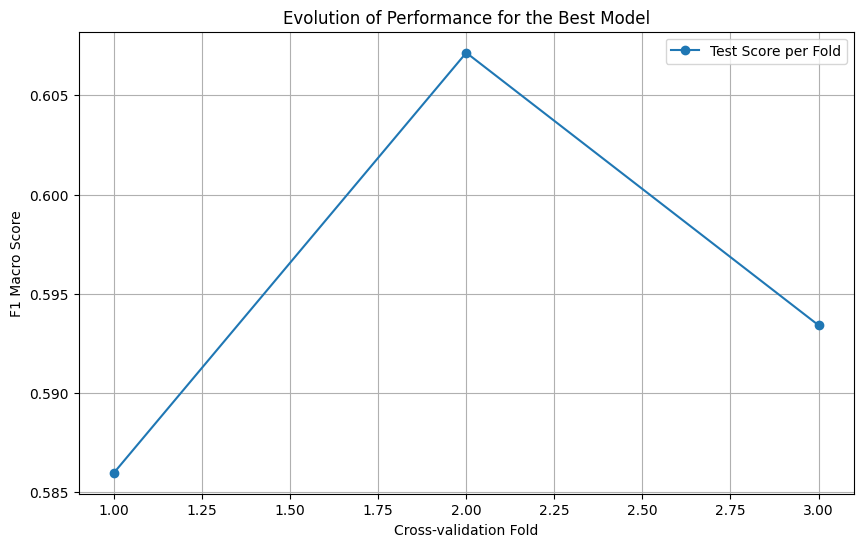

In [1500]:
plot_cv_performance(grid_search, actionOrGender='gender')

#### Plot loss curve (only for MLP Classifier)

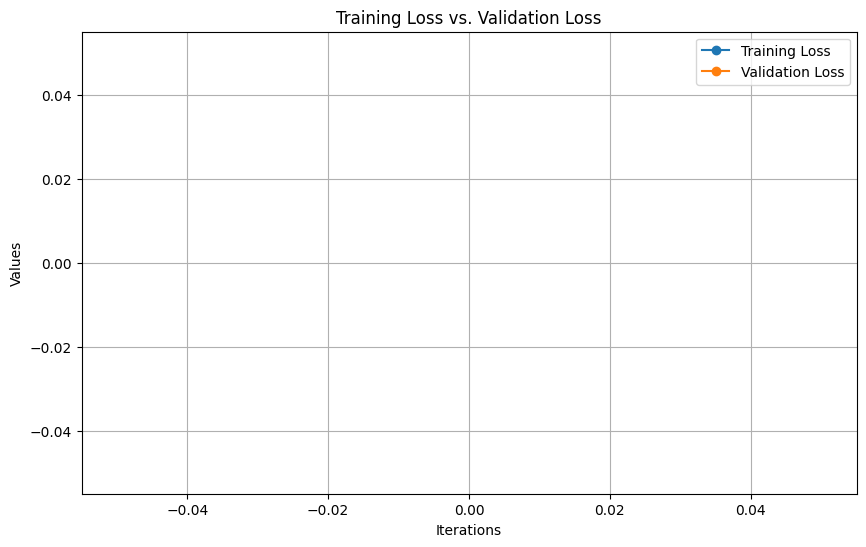

In [1501]:
# Extract loss and validation scores
train_loss, val_scores = extract_loss_and_validation(lossFileName)

# Plot the loss and validation scores
plot_loss_and_validation(train_loss, val_scores)

#### Save the trained model if needed later

In [1502]:
filename = "output/trained_models/" +gameID + "_gender_model_"+ ClassifierID + "_" + wholeOrPart + ".pkl"

# Save the Action/Character model
joblib.dump(grid_search, filename)
print("Gender model saved as " + filename)

Gender model saved as output/trained_models/Horizon_Zero_Dawn_gender_model_MultinomialNB_whole.pkl


### Evaluate the model

#### Predict on the test set and print classification report

In [1503]:
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Save the classification report to a file
with open("output/classification_report/" + gameID + "_" + ClassifierID + "_gender_" + wholeOrPart + "_classification_report.txt", 'w') as f:
    f.write(classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

      female       0.47      0.32      0.38        22
        male       0.44      0.60      0.51        20

    accuracy                           0.45        42
   macro avg       0.46      0.46      0.44        42
weighted avg       0.46      0.45      0.44        42



#### Plot Confusion Matrix

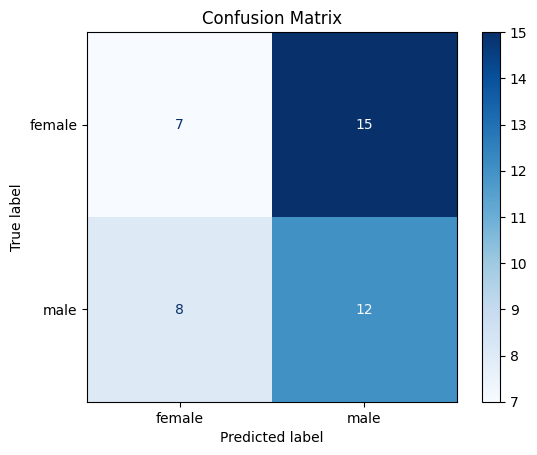

In [1504]:
# Plotting the confusion matrix
plot_confusion_matrix(y_test, y_pred, best_model.classes_, actionOrGender='gender')

#### Print Wrong Cases to get an overview

In [1505]:

print_wrong_cases(y_pred, y_test, X_test, actionOrGender='gender')

Cases where the model was wrong:
Predicted: female, Actual: male, Dialogue: When sleep refuses to come, I think of our wedding night. How you welcomed me to the marital bed. How, after, when you fell to sleep, I lay there watching your delicate face. For all its beauty, I detested its... fragility. A rage swelled up inside me. I abhorred that bed, how its softness threatened to swallow us up. And that room; the stench of incense, the fine embroidery of the drapes. All of it - weak. I slipped from the bed, threw open the casement, and lay naked on the stone floor, determined to spurn all seductions of comfort. But when I woke the next morning, you lay beside me, naked as I in the cold. Your body, stretched beside mine, seemed chiseled from stone. I saw you wake. Instantly alert, like an animal ready to strike. You said nothing. You did not have to. Already you had shown me, beyond doubt, that we were meant to be.
Predicted: female, Actual: male, Dialogue: In emergencies!
Predicted: fema

## Additional : Test a trained model on new data (manually)

### Load the trained model and the test dataset

In [1511]:
#load a given trained model
def load_model(filename):
    return joblib.load(filename)

#Model parameters
modelGameID = "Skyrim_hzd_ffXIII-2_DS"
modelClassifierID = "MLPClassifier" #To save trained models with the classifier name
modelWholeOrPart = "part" #To create filenames

filename = "output/trained_models/" + modelGameID + "_gender_model_"+ modelClassifierID + "_" + modelWholeOrPart + ".pkl"

#load the model
loaded_model = load_model(filename)

# Test the loaded model on a new sample
testPaths = [hadesPath] #Paths to the datasets used
testGameID = "Hades"
testData, testMeta = open_data_and_meta_files(testPaths)
test_df = getDataFrame(testData, testMeta, testGameID)

test_gender_df = process_dataset_for_gender_classification(test_df)

Original DataFrame size: (23571, 4)
Character filtered DataFrame size: (23571, 4)
Gender filtered DataFrame size :  (20291, 4)

Non-gendered lines filtering removed :
                                    dialogue      label    character_name  \
319    All right, then, keep your secrets...  CHARACTER   DROPPED_Zagreus   
491                               Die again.  CHARACTER   DROPPED_Zagreus   
522                             Elimination.  CHARACTER             Chaos   
523                   Returned to the abyss.  CHARACTER             Chaos   
524                              Inevitable.  CHARACTER             Chaos   
...                                      ...        ...               ...   
23346                              He's mad!  CHARACTER   DROPPED_Zagreus   
23348                         Here he comes!  CHARACTER   DROPPED_Zagreus   
23352              Let's all calm down, OK?!  CHARACTER   DROPPED_Zagreus   
23540                        Prepare to die.  CHARACTER  DROPPE

### Predict

Classification Report:
               precision    recall  f1-score   support

      female       0.18      0.22      0.20      4143
        male       0.79      0.74      0.76     16148

    accuracy                           0.64     20291
   macro avg       0.49      0.48      0.48     20291
weighted avg       0.66      0.64      0.65     20291



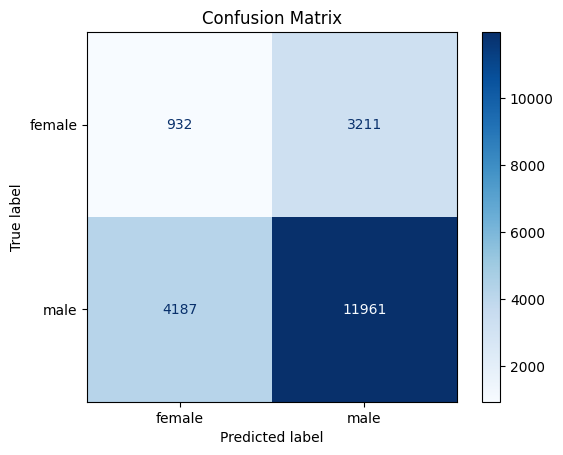

In [1512]:
#Predict

y_pred = loaded_model.predict(test_gender_df['dialogue'])
print("Classification Report:\n", classification_report(test_gender_df['character_group'], y_pred))

#Confusion matrix

cm = confusion_matrix(test_gender_df['character_group'], y_pred, labels=loaded_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=loaded_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
